Understanding the mean function in George...

from https://george.readthedocs.io/en/latest/tutorials/model/

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george.modeling import Model
import os
import sys

sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import dipole

### generate fake data

the model:

single Gaussian feature with 3 parameters; correlated noise

In [6]:
# true model for the data
class Model(Model):
    parameter_names = ("amp", "location", "log_sigma2")

    def get_value(self, t):
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))

Text(0.5, 1.0, 'simulated data')

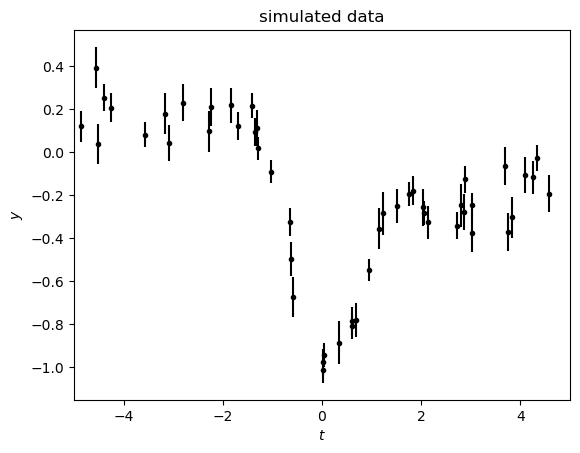

In [7]:
np.random.seed(1234)

def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * george.kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    return t, y, yerr

truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
t, y, yerr = generate_data(truth, 50)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-5, 5)
plt.title("simulated data")

### fit to this data!

start by assuming uncorrelated noise;

simultaneously model a linear trend and the Gaussian feature:

In [9]:
class PolynomialModel(Model):
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        print("get_value called!")
        print(type(t), t.shape)
        print(t)
        t = t.flatten()
        return (t * self.m + self.b +
                self.amp * np.exp(-0.5*(t-self.location)**2*np.exp(-self.log_sigma2)))

In [10]:
# initialize GP
mean = PolynomialModel(m=0, b=0, amp=-1, location=0.1, log_sigma2=np.log(0.4))
model = george.GP(mean=mean)

In [11]:
print('p init:', model.get_parameter_vector())

p init: [ 0.          0.         -1.          0.1        -0.91629073]


In [12]:
model.parameter_vector

array([  0.        ,   0.        ,  -1.        ,   0.1       ,
        -0.91629073, -27.40787756])

In [13]:
# where does this last value come from ??

In [15]:
# pre-compute the covariance matrix
#   and factorize it for a set of times and uncertainties
model.compute(t, yerr)
print('p compute:', model.get_parameter_vector())

p compute: [ 0.          0.         -1.          0.1        -0.91629073]


In [17]:
print('lnlike compute:', model.log_likelihood(y))

get_value called!
<class 'numpy.ndarray'> (50,)
[-4.8623155  -4.56675937 -4.52644721 -4.40190777 -4.24618758 -3.56233175
 -3.15712916 -3.0848055  -2.81207894 -2.27407395 -2.23535745 -1.83163878
 -1.70331554 -1.4218273  -1.35114016 -1.31175994 -1.29749245 -1.02797422
 -0.63826576 -0.62272261 -0.57859245  0.00995126  0.02966833  0.03083165
  0.33310163  0.61196186  0.6143308   0.68098653  0.9462478   1.15396178
  1.22108771  1.51378143  1.74880944  1.83462935  2.04260971  2.04581308
  2.12702027  2.72826622  2.79975808  2.85358584  2.88730143  3.01872178
  3.02147642  3.6912739   3.75932635  3.82641191  4.09315959  4.24867629
  4.33140102  4.58139354]
lnlike compute: -84.54732693061757
